##### Copyright 2018 The TensorFlow Authors.


In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load text

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/text"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/text.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates two ways to load and preprocess text.

- First, you will use Keras utilities and preprocessing layers. These include `tf.keras.utils.text_dataset_from_directory` to turn data into a `tf.data.Dataset` and `tf.keras.layers.TextVectorization` for data standardization, tokenization, and vectorization. If you are new to TensorFlow, you should start with these.
- Then, you will use lower-level utilities like `tf.data.TextLineDataset` to load text files, `tf.lookup` for custom in-model lookup tables, and [TensorFlow Text](https://www.tensorflow.org/text) APIs, such as `text.UnicodeScriptTokenizer` and `text.case_fold_utf8`, to preprocess the data for finer-grain control.

In [9]:
!pip install "tensorflow-text" matplotlib tensorflow_datasets ipywidgets --quiet

In [10]:
import collections
import pathlib

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

## Example 1: Predict the tag for a Stack Overflow question

As a first example, you will download a dataset of programming questions from Stack Overflow. Each question (_"How do I sort a dictionary by value?"_) is labeled with exactly one tag (`Python`, `CSharp`, `JavaScript`, or `Java`). Your task is to develop a model that predicts the tag for a question. This is an example of multi-class classification—an important and widely applicable kind of machine learning problem.

To implement this task, you'll start with the simplest tools:

* `keras.utils.text_datasaet_from_directory`: for loading text-file examples.
* `keras.layers.TextVectorization`: for converting strings to token indices.


### Download and explore the dataset

Begin by downloading the Stack Overflow dataset using `tf.keras.utils.get_file`, and exploring the directory structure:

In [11]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='stack_overflow',
    cache_subdir='')

dataset_dir = pathlib.Path(dataset_dir).parent

In [12]:
list(dataset_dir.iterdir())

[PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/README.md'),
 PosixPath('/tmp/.keras/train')]

In [13]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/python'),
 PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript')]

The `train/csharp`, `train/java`, `train/python` and `train/javascript` directories contain many text files, each of which is a Stack Overflow question.

Print an example file and inspect the data:

In [14]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file) as f:
  print(f.read())

why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



### Load the dataset

Next, you will load the data off-disk and prepare it into a format suitable for training. To do so, you will use the `tf.keras.utils.text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. If you're new to `tf.data`, it's a powerful collection of tools for building input pipelines. (Learn more in the [tf.data: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.)

The `tf.keras.utils.text_dataset_from_directory` API expects a directory structure as follows:

```
train/
...csharp/
......1.txt
......2.txt
...java/
......1.txt
......2.txt
...javascript/
......1.txt
......2.txt
...python/
......1.txt
......2.txt
```

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [training](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The Stack Overflow dataset has already been divided into training and test sets, but it lacks a validation set.

Create a validation set using an 80:20 split of the training data by using `tf.keras.utils.text_dataset_from_directory` with `validation_split` set to `0.2` (i.e. 20%):

In [14]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As the previous cell output suggests, there are 8,000 examples in the training folder, of which you will use 80% (or 6,400) for training. You will learn in a moment that you can train a model by passing a `tf.data.Dataset` directly to `Model.fit`.

First, iterate over the dataset and print out a few examples, to get a feel for the data.

Note: To increase the difficulty of the classification problem, the dataset author replaced occurrences of the words *Python*, *CSharp*, *JavaScript*, or *Java* in the programming question with the word *blank*.

In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Question: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

The labels are `0`, `1`, `2` or `3`. To check which of these correspond to which string label, you can inspect the `class_names` property on the dataset:


In [16]:
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and a test set using `tf.keras.utils.text_dataset_from_directory`. You will use the remaining 1,600 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments of `tf.keras.utils.text_dataset_from_directory`, make sure to either specify a random seed or pass `shuffle=False`, so that the validation and training splits have no overlap.

In [20]:
# Create a validation set.
raw_val_ds = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [21]:
test_dir = dataset_dir/'test'

# Create a test set.
raw_test_ds = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Configure the datasets for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

- `Dataset.cache` keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [23]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_test_ds = raw_test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

This first example will keep things simple by integrating the text processing into the model. But you may be able to increase performance by moving the text processing into the dataset pipeline, this is demonstrated in [Example 2](#example2)

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the `tf.keras.layers.TextVectorization` layer.

- _Standardization_ refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
- _Tokenization_ refers to splitting strings into tokens (for example, splitting a sentence into individual words by splitting on whitespace).
- _Vectorization_ refers to converting tokens into numbers so they can be fed into a neural network.

All of these tasks can be accomplished with this layer. (You can learn more about each of these in the `tf.keras.layers.TextVectorization` API docs.)

Note that:

- The default standardization converts text to lowercase and removes punctuation (`standardize='lower_and_strip_punctuation'`).
- The default tokenizer splits on whitespace (`split='whitespace'`).
- The default vectorization mode is `'int'` (`output_mode='int'`). This outputs integer indices (one per token). This mode can be used to build models that take word order into account. You can also use other modes—like `'binary'`—to build [bag-of-words](https://developers.google.com/machine-learning/glossary#bag-of-words) models.

You will build two models to learn more about standardization, tokenization, and vectorization with `TextVectorization`:

- First, you will use the `'binary'` vectorization mode to build a bag-of-words model.
- Then, you will use the `'int'` mode with a 1D ConvNet.

In [28]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

For the `'int'` mode, in addition to maximum vocabulary size, you need to set an explicit maximum sequence length (`MAX_SEQUENCE_LENGTH`), which will cause the layer to pad or truncate sequences to exactly `output_sequence_length` values:

In [29]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

Next, call `TextVectorization.adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling `TextVectorization.adapt`, as using the test set would leak information.

In [32]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Print the result of using these layers to preprocess data:

In [33]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int32)


The binary vectorization layer returns a multi-hot vector, with a 1 in the location for each token that was in the input string.

'binary' vectorized question: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,

(0.0, 1000.0)

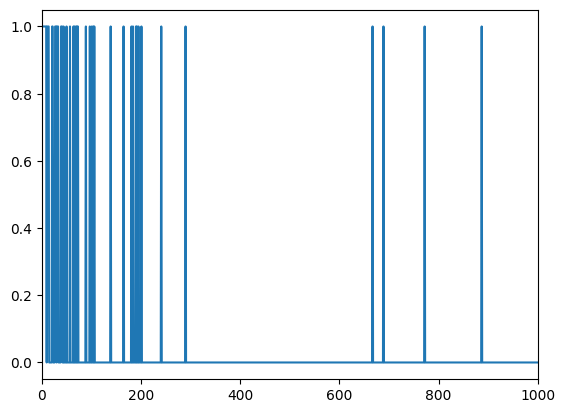

In [35]:
print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

In [36]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [1011  773    9 2456    8 1863 2362  690 1267    4   40    5    1 1011
  196   12   74   13   72   33    2   98  105   14    3   70 9611    3
   34  888  202  773  107    8   41  242   40   58  291   90    3  196
  191   10    2  182    6  668    6   13   30 1187   12  773   22   42
    1   28    5  140   29 5213   15   29    1   28   51    1    1    1
    7   23   30    3  291   10   67    6   32   65  185  166  102   14
    2   65    6    1  193    9 2784   45 2410    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

As shown above, `TextVectorization`'s `'binary'` mode returns an array denoting which tokens exist at least once in the input, while the `'int'` mode replaces each token by an integer, thus preserving their order.

You can lookup the token (string) that each integer corresponds to by calling `TextVectorization.get_vocabulary` on the layer:

In [37]:
print("1289 ---> ", int_vectorize_layer.get_vocabulary()[1289])
print("313 ---> ", int_vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

1289 --->  roman
313 --->  source
Vocabulary size: 10000


### Train the model

It's time to create your neural network.

For the `'binary'` vectorized data, define a simple bag-of-words linear model, then configure and train it:

In [38]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

tf.keras.utils.plot_model(binary_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
bin_history = binary_model.fit(
    raw_train_ds, validation_data=raw_val_ds, epochs=10)

print()

Epoch 1/30
 12/200 [>.............................] - ETA: 0s - loss: 0.3036 - accuracy: 0.9401

200/200 [==============================] - 1s 6ms/step - loss: 0.2701 - accuracy: 0.9553 - val_loss: 0.4810 - val_accuracy: 0.8400
Epoch 2/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2512 - accuracy: 0.9592 - val_loss: 0.4748 - val_accuracy: 0.8381
Epoch 3/30
200/200 [==============================] - 1s 6ms/step - loss: 0.2343 - accuracy: 0.9620 - val_loss: 0.4699 - val_accuracy: 0.8363
Epoch 4/30
200/200 [==============================] - 1s 5ms/step - loss: 0.2191 - accuracy: 0.9670 - val_loss: 0.4661 - val_accuracy: 0.8375
Epoch 5/30
200/200 [==============================] - 1s 5ms/step - loss: 0.2053 - accuracy: 0.9706 - val_loss: 0.4631 - val_accuracy: 0.8381
Epoch 6/30
200/200 [==============================] - 1s 5ms/step - loss: 0.1928 - accuracy: 0.9739 - val_loss: 0.4608 - val_accuracy: 0.8375
Epoch 7/30
200/200 [==============================] - 1s 5ms/step - loss: 0.1812 - accuracy: 0.9770 - val_loss: 0.4592 - val_accuracy: 0.8388
Epoch 8/30
200/20

Next, you will use the `'int'` vectorized layer to build a 1D ConvNet:

In [43]:
def create_model(vocab_size, num_labels, vectorizer=None):
  my_layers =[]
  if vectorizer is not None:
    my_layers = [vectorizer]

  my_layers.extend([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Dropout(0.5),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])

  model = tf.keras.Sequential(my_layers)
  return model

In [44]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4, vectorizer=int_vectorize_layer)

tf.keras.utils.plot_model(int_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:

int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
int_history = int_model.fit(raw_train_ds, validation_data=raw_val_ds, epochs=30)

Epoch 1/30


200/200 [==============================] - 9s 37ms/step - loss: 0.0480 - accuracy: 0.9887 - val_loss: 0.7027 - val_accuracy: 0.8100
Epoch 2/30
200/200 [==============================] - 7s 35ms/step - loss: 0.0327 - accuracy: 0.9931 - val_loss: 0.7637 - val_accuracy: 0.8031
Epoch 3/30
200/200 [==============================] - 8s 40ms/step - loss: 0.0259 - accuracy: 0.9952 - val_loss: 0.8005 - val_accuracy: 0.8056
Epoch 4/30
200/200 [==============================] - 8s 40ms/step - loss: 0.0192 - accuracy: 0.9962 - val_loss: 0.8529 - val_accuracy: 0.8025
Epoch 5/30
200/200 [==============================] - 8s 42ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.8835 - val_accuracy: 0.8031
Epoch 6/30
200/200 [==============================] - 9s 45ms/step - loss: 0.0132 - accuracy: 0.9975 - val_loss: 0.9051 - val_accuracy: 0.8037
Epoch 7/30
200/200 [==============================] - 9s 45ms/step - loss: 0.0122 - accuracy: 0.9972 - val_loss: 0.9288 - val_accuracy: 0.8031
Epoch 8/30

Text(0, 0.5, 'CE/token')

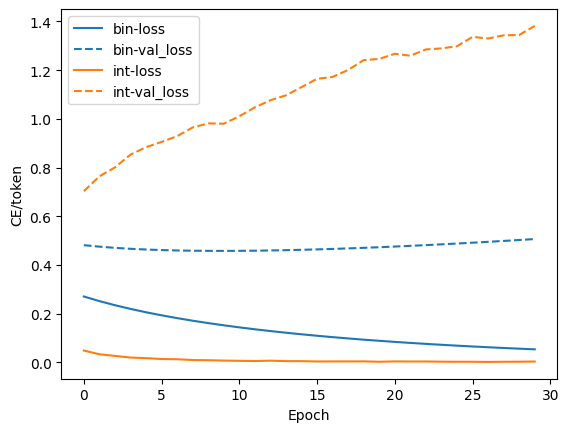

In [47]:
loss = plt.plot(bin_history.epoch, bin_history.history['loss'], label='bin-loss')
plt.plot(bin_history.epoch, bin_history.history['val_loss'], '--', color=loss[0].get_color(), label='bin-val_loss')

loss = plt.plot(int_history.epoch, int_history.history['loss'], label='int-loss')
plt.plot(int_history.epoch, int_history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

You are nearly ready to train your model.

As a final preprocessing step, you will apply the `TextVectorization` layers you created earlier to the training, validation, and test sets:

In [48]:
binary_train_ds = raw_train_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_val_ds = raw_val_ds.map(lambda x,y: (binary_vectorize_layer(x), y))
binary_test_ds = raw_test_ds.map(lambda x,y: (binary_vectorize_layer(x), y))

int_train_ds = raw_train_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_val_ds = raw_val_ds.map(lambda x,y: (int_vectorize_layer(x), y))
int_test_ds = raw_test_ds.map(lambda x,y: (int_vectorize_layer(x), y))

### Export the model

In [49]:
binary_model.export('bin.tf')

INFO:tensorflow:Assets written to: bin.tf/assets


INFO:tensorflow:Assets written to: bin.tf/assets


Saved artifact at 'bin.tf'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: string Tensor, shape=(None,)
  Returns:
    float32 Tensor, shape=(None, 4)


In [51]:
loaded = tf.saved_model.load('bin.tf')

In [52]:
binary_model.predict(['How do you sort a list?'])

1/1 [==============================] - 0s 226ms/step


array([[-0.0937058 ,  0.05841638, -0.9982403 ,  0.5761605 ]],
      dtype=float32)

In [53]:
loaded.serve(tf.constant(['How do you sort a list?'])).numpy()

array([[-0.0937058 ,  0.05841638, -0.9982403 ,  0.5761605 ]],
      dtype=float32)


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply `tf.keras.layers.TextVectorization`. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the `TextVectorization` layer inside your model when you're ready to prepare for deployment.

Visit the [Save and load models](../keras/save_and_load.ipynb) tutorial to learn more about saving models.

<a name="example2">

## Example 2: Predict the author of Iliad translations

The following provides an example of using `tf.data.TextLineDataset` to load examples from text files, and [TensorFlow Text](https://www.tensorflow.org/text) to preprocess the data. You will use three different English translations of the same work, Homer's Iliad, and train a model to identify the translator given a single line of text.

To implement this task you'll use some lower level tools.

* You'll use `tf.data.TextLineDataset` to load text-lines from files.
* You'll implement your own version of `keras.layers.TextVectorization` using:
  * `text.UnicodeScriptTokenizer` - to convert strings to tokens.
  * `tf.lookup.StaticVocabularyTable` - to convert tokens to integer ids.
* You'll maximize performance by placing the text processing in the dataset pipeline, so it can run in parallel with the model training.

### Download and explore the dataset

The texts of the three translations are by:

- [William Cowper](https://en.wikipedia.org/wiki/William_Cowper): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/cowper.txt)
- [Edward, Earl of Derby](https://en.wikipedia.org/wiki/Edward_Smith-Stanley,_14th_Earl_of_Derby): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/derby.txt)
- [Samuel Butler](https://en.wikipedia.org/wiki/Samuel_Butler_%28novelist%29): [text](https://storage.googleapis.com/download.tensorflow.org/data/illiad/butler.txt)

The text files used in this tutorial have undergone some typical preprocessing tasks like removing document header and footer, line numbers and chapter titles.

Download these lightly munged files locally:

In [54]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = utils.get_file(name, origin=DIRECTORY_URL + name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir())

807992/807992 [==============================] - 0s 0us/step


[PosixPath('/Users/osmanjalloh/.keras/datasets/cowper.txt'),
 PosixPath('/Users/osmanjalloh/.keras/datasets/cifar-10-batches-py'),
 PosixPath('/Users/osmanjalloh/.keras/datasets/mnist.npz'),
 PosixPath('/Users/osmanjalloh/.keras/datasets/butler.txt'),
 PosixPath('/Users/osmanjalloh/.keras/datasets/cifar-10-batches-py.tar.gz'),
 PosixPath('/Users/osmanjalloh/.keras/datasets/derby.txt')]

### Load the dataset

Previously, with `tf.keras.utils.text_dataset_from_directory` all contents of a file were treated as a single example. Here, you will use `tf.data.TextLineDataset`, which is designed to create a `tf.data.Dataset` from a text file where each example is a line of text from the original file. `TextLineDataset` is useful for text data that is primarily line-based (for example, poetry or error logs).

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use `Dataset.map` to apply a labeler function to each one. This will iterate over every example in the dataset, returning (`example, label`) pairs.

In [55]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)

In [56]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(str(parent_dir/file_name))
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

Next, you'll combine these labeled datasets into a single dataset using `Dataset.concatenate`, and shuffle it with `Dataset.shuffle`:


In [57]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [58]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

Print out a few examples as before. The dataset hasn't been batched yet, hence each entry in `all_labeled_data` corresponds to one data point:

In [59]:
for text, label in all_labeled_data.take(10):
  print("Sentence: ", text.numpy())
  print("Label:", label.numpy())

Sentence:  b'Supine, and backward thursting it, he drew'
Label: 0
Sentence:  b'He left the wall, and stood above the ditch,'
Label: 1
Sentence:  b'Above the pap, \xc3\x86tolian Thoas pierced,'
Label: 0
Sentence:  b'round another.'
Label: 2
Sentence:  b"Was Ajax, but, advancing rapid, stalk'd"
Label: 0
Sentence:  b'and Mases; these were led by Diomed of the loud battle-cry, and'
Label: 2
Sentence:  b'you not go to this man, the son of Tydeus, who would now fight even'
Label: 2
Sentence:  b"Be unfulfill'd my words! yet much I fear"
Label: 1
Sentence:  b'Sevenfold of Ajax with that stone he smote'
Label: 0
Sentence:  b'Appear, himself to consecrate our oaths,'
Label: 1


### Prepare the dataset for training

Instead of using `tf.keras.layers.TextVectorization` to preprocess the text dataset, you will now use the lower-level TensorFlow Text APIs to standardize and tokenize the data, build a vocabulary and use `tf.lookup.StaticVocabularyTable` to map tokens to integers to feed to the model. (Learn more about [TensorFlow Text](https://www.tensorflow.org/text)).

Define a function to convert the text to lower-case and tokenize it:

- TensorFlow Text provides various tokenizers. In this example, you will use the `text.UnicodeScriptTokenizer` to tokenize the dataset.
- You will use `Dataset.map` to apply the tokenization to the dataset.

In [62]:
class MyTokenizer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.tokenizer = tf_text.UnicodeScriptTokenizer()

  def call(self, text):
    lower_case = tf_text.case_fold_utf8(text)
    result = self.tokenizer.tokenize(lower_case)
    # If you pass a batch of strings, it will return a RaggedTensor.
    if isinstance(result, tf.RaggedTensor):
      # Convert to dense 0-padded.
      result = result.to_tensor()
    return result

In [63]:
tokenizer = MyTokenizer()

In [64]:
tokenized_ds = all_labeled_data.map(lambda text, label: (tokenizer(text), label))
tokenized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

You can iterate over the dataset and print out a few tokenized examples:


In [65]:
for tokens, label in tokenized_ds.take(1):
  break

print(tokens)
print()
print(label)

tf.Tensor([b'supine' b',' b'and' b'backward' b'thursting' b'it' b',' b'he' b'drew'], shape=(9,), dtype=string)

tf.Tensor(0, shape=(), dtype=int64)


Next, you will build a vocabulary by sorting tokens by frequency and keeping the top `VOCAB_SIZE` tokens:

In [71]:
tokenized_ds = tokenized_ds.cache().prefetch(tf.data.AUTOTUNE)

vocab_count = collections.Counter()
for toks, labels in tokenized_ds.ragged_batch(1000):
  toks = tf.reshape(toks, [-1])
  for tok in toks.numpy():
    vocab_count[tok] += 1

vocab = [tok for tok, count in vocab_count.most_common(VOCAB_SIZE)]

print("First five vocab entries:", vocab[:5])
print()

First five vocab entries: [b',', b'the', b'and', b"'", b'of']



To convert the tokens into integers, use the `vocab` set to create a `tf.lookup.StaticVocabularyTable`. You will map tokens to integers with `0` reserved for padding, and `n+1` reserved to denote an out-of-vocabulary (OOV) token.

In [69]:
class MyVocabTable(tf.keras.layers.Layer):
  def __init__(self, vocab):
    super().__init__()
    self.keys = [''] + vocab
    self.values = range(len(self.keys))

    self.init = tf.lookup.KeyValueTensorInitializer(
        self.keys, self.values, key_dtype=tf.string, value_dtype=tf.int64)

    num_oov_buckets = 1

    self.table = tf.lookup.StaticVocabularyTable(self.init, num_oov_buckets)

  def call(self, x):
    result = self.table.lookup(x)
    return result

Try it on a dummy vocabulary:

In [70]:
vocab_table = MyVocabTable(['a','b','c'])
vocab_table(tf.constant([''] + list('abcdefghi')))

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 2, 3, 4, 4, 4, 4, 4, 4])>

Create one for the real vocabulary:

In [72]:
vocab_table = MyVocabTable(vocab)

Finally, define a layer to standardize, tokenize and vectorize the dataset using the tokenizer and lookup table:

In [73]:
preprocess_text = tf.keras.Sequential([
    tokenizer,
    vocab_table
])

You can try this on a single example to print the output:

In [74]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text = preprocess_text(example_text)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'Supine, and backward thursting it, he drew'
Vectorized sentence:  [2096    1    3 1212 9790   34    1   11  331]


Now create a dataset pipeline that will process the text on the fly using `Dataset.map`:

In [75]:
all_encoded_data = all_labeled_data.map(lambda text, labels:(preprocess_text(text), labels))

for ids, label in all_encoded_data.take(1):
  break

print("Ids: ", ids.numpy())
print("Label: ", label.numpy())

Ids:  [2096    1    3 1212 9790   34    1   11  331]
Label:  0


### Split the dataset into training and test sets


The Keras `TextVectorization` layer also batches and pads the vectorized data. Padding is required because the examples inside of a batch need to be the same size and shape, but the examples in these datasets are not all the same size—each line of text has a different number of words.

`tf.data.Dataset` supports splitting and padded-batching datasets:

In [76]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE).padded_batch(BATCH_SIZE)

Now, `validation_data` and `train_data` are not collections of (`example, label`) pairs, but collections of batches. Each batch is a pair of (*many examples*, *many labels*) represented as arrays.

To illustrate this:

In [77]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 18)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[2096    1    3 1212 9790   34    1   11  331    0    0    0    0    0
    0    0    0    0], shape=(18,), dtype=int64)
First label example:  tf.Tensor(0, shape=(), dtype=int64)


Configure the datasets for better performance as before:

In [78]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

### Train the model

You can train a model on this dataset as before:

Since this text vectorization adds `0` for padding and `n+1` for out-of-vocabulary (OOV) tokens, the vocabulary size has increased by two:

In [79]:
model = create_model(vocab_size=VOCAB_SIZE+2, num_labels=3)

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [81]:
!pip install pydot

In [82]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [84]:
history = model.fit(train_data, validation_data=validation_data, epochs=10)

Epoch 1/10


2023-11-10 22:23:45.079994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:24:01.971056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 10744 of 50000
2023-11-10 22:24:21.961957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 23039 of 50000
2023-11-10 22:24:31.962905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 29207 of 50000
2023-11-10 22:24:41.962471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 34914 of 50000
2023-11-10 22:24:51.993031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer 

697/697 [==============================] - 129s 59ms/step - loss: 0.2449 - accuracy: 0.9034 - val_loss: 0.3736 - val_accuracy: 0.8438
Epoch 2/10


2023-11-10 22:25:52.683377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:26:10.935986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 11197 of 50000
2023-11-10 22:26:20.936819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 17324 of 50000
2023-11-10 22:26:40.936387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 28521 of 50000
2023-11-10 22:26:50.937379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 34344 of 50000
2023-11-10 22:27:00.935723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer 

  3/697 [..............................] - ETA: 40s - loss: 0.2731 - accuracy: 0.9115     

2023-11-10 22:27:08.230327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 129s 59ms/step - loss: 0.2122 - accuracy: 0.9166 - val_loss: 0.3984 - val_accuracy: 0.8388
Epoch 3/10


2023-11-10 22:28:00.268684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:28:19.687674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 12460 of 50000
2023-11-10 22:28:39.660668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 24524 of 50000
2023-11-10 22:28:59.659915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 37609 of 50000
2023-11-10 22:29:09.665742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 43508 of 50000


  1/697 [..............................] - ETA: 15:56:46 - loss: 0.1241 - accuracy: 0.9531

2023-11-10 22:29:12.022923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 134s 74ms/step - loss: 0.1868 - accuracy: 0.9283 - val_loss: 0.4123 - val_accuracy: 0.8392
Epoch 4/10


2023-11-10 22:30:16.758560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:30:34.962973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 12911 of 50000
2023-11-10 22:30:54.961406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 26001 of 50000
2023-11-10 22:31:04.965873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 32718 of 50000
2023-11-10 22:31:22.843238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 135s 80ms/step - loss: 0.1655 - accuracy: 0.9353 - val_loss: 0.4235 - val_accuracy: 0.8420
Epoch 5/10


2023-11-10 22:32:34.081080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:32:50.427539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 9770 of 50000
2023-11-10 22:33:10.421867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 22248 of 50000
2023-11-10 22:33:20.470400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 28651 of 50000
2023-11-10 22:33:40.429947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 40618 of 50000
2023-11-10 22:33:48.104367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 151s 90ms/step - loss: 0.1492 - accuracy: 0.9417 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 6/10


2023-11-10 22:35:03.845495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:35:22.155630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 11593 of 50000
2023-11-10 22:35:32.153647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 17832 of 50000
2023-11-10 22:35:42.155071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 24038 of 50000
2023-11-10 22:36:02.152442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 36486 of 50000
2023-11-10 22:36:12.153941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer 

697/697 [==============================] - 123s 59ms/step - loss: 0.1340 - accuracy: 0.9486 - val_loss: 0.4675 - val_accuracy: 0.8368
Epoch 7/10


2023-11-10 22:37:06.152162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:37:25.473314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 13085 of 50000
2023-11-10 22:37:35.485585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 19889 of 50000
2023-11-10 22:37:55.474113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 32669 of 50000
2023-11-10 22:38:05.473883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 39260 of 50000


  1/697 [..............................] - ETA: 15:08:52 - loss: 0.1192 - accuracy: 0.9531

2023-11-10 22:38:13.672331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 120s 60ms/step - loss: 0.1267 - accuracy: 0.9516 - val_loss: 0.4804 - val_accuracy: 0.8428
Epoch 8/10


2023-11-10 22:39:09.473671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:39:26.296506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 10701 of 50000
2023-11-10 22:39:36.280433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 16875 of 50000
2023-11-10 22:39:56.273672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 29806 of 50000
2023-11-10 22:40:06.273199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 36167 of 50000
2023-11-10 22:40:16.271949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer 

  1/697 [..............................] - ETA: 16:09:32 - loss: 0.1957 - accuracy: 0.9219

2023-11-10 22:40:19.676581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 131s 68ms/step - loss: 0.1172 - accuracy: 0.9542 - val_loss: 0.5006 - val_accuracy: 0.8328
Epoch 9/10


2023-11-10 22:41:17.861439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 1 of 50000
2023-11-10 22:41:37.670364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 12350 of 50000
2023-11-10 22:41:47.670589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 18464 of 50000
2023-11-10 22:42:07.696946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 31111 of 50000
2023-11-10 22:42:27.672383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 44018 of 50000
2023-11-10 22:42:28.570240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 125s 63ms/step - loss: 0.1055 - accuracy: 0.9593 - val_loss: 0.5173 - val_accuracy: 0.8392
Epoch 10/10


2023-11-10 22:43:22.703137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 481 of 50000
2023-11-10 22:43:32.700387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 6814 of 50000
2023-11-10 22:43:42.704329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 13370 of 50000
2023-11-10 22:44:02.714276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 26394 of 50000
2023-11-10 22:44:22.701353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:135: Filling up shuffle buffer (this may take a while): 39214 of 50000
2023-11-10 22:44:30.721340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


697/697 [==============================] - 125s 66ms/step - loss: 0.1019 - accuracy: 0.9616 - val_loss: 0.5413 - val_accuracy: 0.8312


In [85]:
metrics = model.evaluate(validation_data, return_dict=True)

print("Loss: ", metrics['loss'])
print("Accuracy: {:2.2%}".format(metrics['accuracy']))

79/79 [==============================] - 5s 37ms/step - loss: 0.5413 - accuracy: 0.8312
Loss:  0.5412967205047607
Accuracy: 83.12%


### Export the model

To make the model capable of taking raw strings as input, pack both the text processor and the model into a `keras.Sequential`:

In [86]:
export_model = tf.keras.Sequential([
    preprocess_text,
    model
])

In [87]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

This model you can run directly on batches of strings:

In [88]:
# Create a test dataset of raw strings.
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [89]:
loss, accuracy = export_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 31s 43ms/step - loss: 1.2396 - accuracy: 0.8312
Loss:  1.2395762205123901
Accuracy: 83.12%


Use `saved_model.save` to export it.

<!-- TODO: After 2.15 switch this to use Model.export -->

In [90]:
tf.saved_model.save(export_model, 'export.tf')

INFO:tensorflow:Assets written to: export.tf/assets


INFO:tensorflow:Assets written to: export.tf/assets


In [91]:
loaded = tf.saved_model.load('export.tf')

In [92]:
export_model(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

array([[-4.701753  , -0.14039388,  5.0616803 ]], dtype=float32)

In [93]:
loaded(tf.constant(['The field bristled with the long and deadly spears which they bore.'])).numpy()

2023-11-10 22:54:29.911846: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/StatefulPartitionedCall/sequential_3/StatefulPartitionedCall/my_tokenizer_1/UnicodeScriptTokenize/RaggedConcat/assert_equal_1/Assert/AssertGuard/branch_executed/_42


array([[-4.701753  , -0.14039388,  5.0616803 ]], dtype=float32)

The loss and accuracy for the model on encoded validation set and the exported model on the raw validation set are the same, as expected.

### Run inference on new data

In [94]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

1/1 [==============================] - 4s 4s/step
Question:  Join'd to th' Ionians with their flowing robes,
Predicted label:  1
Question:  the allies, and his armour flashed about him so that he seemed to all
Predicted label:  2
Question:  And with loud clangor of his arms he fell.
Predicted label:  0


## Download more datasets using TensorFlow Datasets (TFDS)


You can download many more datasets from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview).

In this example, you will use the [IMDB Large Movie Review dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) to train a model for sentiment classification:

In [95]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

2023-11-10 22:55:30.941879: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|██████████| 1/1 [00:14<00:00, 14.13s/ url]


Dataset imdb_reviews downloaded and prepared to /Users/osmanjalloh/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [96]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

Print a few examples:

In [97]:
for review_batch, label_batch in val_ds.take(1):
  for i in range(5):
    print("Review: ", review_batch[i].numpy())
    print("Label: ", label_batch[i].numpy())

Review:  b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label:  0
Review:  b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was

2023-11-10 23:00:20.236455: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


You can now preprocess the data and train a model as before.

Note: You will use `tf.keras.losses.BinaryCrossentropy` instead of `tf.keras.losses.SparseCategoricalCrossentropy` for your model, since this is a binary classification problem.

### Prepare the dataset for training

In [98]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

In [99]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [100]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [101]:
# Configure datasets for performance as before.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

### Create, configure and train the model

In [102]:
model = create_model(vocab_size=VOCAB_SIZE, num_labels=1)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660609 (2.52 MB)
Trainable params: 660609 (2.52 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [103]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

In [104]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 14s 41ms/step - loss: 0.5982 - accuracy: 0.6105 - val_loss: 0.4346 - val_accuracy: 0.7890
Epoch 2/3
313/313 [==============================] - 14s 43ms/step - loss: 0.3769 - accuracy: 0.8262 - val_loss: 0.3426 - val_accuracy: 0.8476
Epoch 3/3
313/313 [==============================] - 11s 36ms/step - loss: 0.2817 - accuracy: 0.8789 - val_loss: 0.3172 - val_accuracy: 0.8598


In [105]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 1s 7ms/step - loss: 0.3172 - accuracy: 0.8598
Loss:  0.3171935975551605
Accuracy: 85.98%


### Export the model

In [106]:
export_model = tf.keras.Sequential(
    [vectorize_layer, model,
     layers.Activation('sigmoid')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [107]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
]

predicted_scores = export_model.predict(inputs)
predicted_labels = [int(round(x[0])) for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

1/1 [==============================] - 0s 260ms/step
Question:  This is a fantastic movie.
Predicted label:  1
Question:  This is a bad movie.
Predicted label:  0
Question:  This movie was so bad that it was good.
Predicted label:  0
Question:  I will never say yes to watching this movie.
Predicted label:  0


## Conclusion

This tutorial demonstrated several ways to load and preprocess text. As a next step, you can explore additional text preprocessing [TensorFlow Text](https://www.tensorflow.org/text) tutorials, such as:

- [BERT Preprocessing with TF Text](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
- [Tokenizing with TF Text](https://www.tensorflow.org/text/guide/tokenizers)
- [Subword tokenizers](https://www.tensorflow.org/text/guide/subwords_tokenizer)

You can also find new datasets on [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). And, to learn more about `tf.data`, check out the guide on [building input pipelines](../../guide/data.ipynb).